In [1]:
# Download the dataset
from google.colab import files
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d wanderdust/skin-lesion-analysis-toward-melanoma-detection

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
100% 11.3G/11.3G [01:34<00:00, 160MB/s]
100% 11.3G/11.3G [01:34<00:00, 129MB/s]


In [2]:
# Unzip the dataset
from zipfile import ZipFile

with ZipFile("/content/skin-lesion-analysis-toward-melanoma-detection.zip","r") as dataset:
  dataset.extractall()

In [3]:
import itertools
import os

import matplotlib.pylab
import numpy

import tensorflow

In [4]:

import tensorflow_datasets

train_data_dir="/content/skin-lesions/train"
test_data_dir="/content/skin-lesions/test"
batch_size = 32
img_height = 300
img_width = 300

train_ds = tensorflow.keras.utils.image_dataset_from_directory(
  train_data_dir,
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2000 files belonging to 3 classes.


In [5]:
val_ds = tensorflow.keras.utils.image_dataset_from_directory(
  test_data_dir,
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 600 files belonging to 3 classes.


In [13]:
AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [7]:
img_shape=(300, 300, 3)
model2  = tensorflow.keras.applications.efficientnet.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    classifier_activation='softmax',
)

43941136/43941136 [==============================] - 0s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = model2(image_batch)
print(feature_batch.shape)

global_average_layer = tensorflow.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tensorflow.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 9, 9, 1536)
(32, 1536)
(32, 3)


In [15]:
model2.trainable = False

In [16]:
preprocess_input = tensorflow.keras.applications.efficientnet.preprocess_input
inputs = tensorflow.keras.Input(shape=(300, 300, 3))
x = preprocess_input(inputs)
x = model2(x, training=False)
x = global_average_layer(x)
x = tensorflow.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tensorflow.keras.Model(inputs, outputs)
base_learning_rate = 0.001
initial_epochs = 10
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[callback])

Epoch 1/10
63/63 [==============================] - 303s 4s/step - loss: 0.8040 - accuracy: 0.6730 - val_loss: 0.7881 - val_accuracy: 0.6583
Epoch 2/10
63/63 [==============================] - 15s 245ms/step - loss: 0.6715 - accuracy: 0.7160 - val_loss: 0.7359 - val_accuracy: 0.6750
Epoch 3/10
63/63 [==============================] - 15s 246ms/step - loss: 0.6326 - accuracy: 0.7385 - val_loss: 0.7161 - val_accuracy: 0.6967
Epoch 4/10
63/63 [==============================] - 16s 248ms/step - loss: 0.6054 - accuracy: 0.7535 - val_loss: 0.6994 - val_accuracy: 0.7083
Epoch 5/10
63/63 [==============================] - 17s 275ms/step - loss: 0.5830 - accuracy: 0.7620 - val_loss: 0.6887 - val_accuracy: 0.7117
Epoch 6/10
63/63 [==============================] - 16s 247ms/step - loss: 0.5663 - accuracy: 0.7640 - val_loss: 0.6825 - val_accuracy: 0.7183
Epoch 7/10
63/63 [==============================] - 17s 274ms/step - loss: 0.5455 - accuracy: 0.7720 - val_loss: 0.6816 - val_accuracy: 0.7233
E

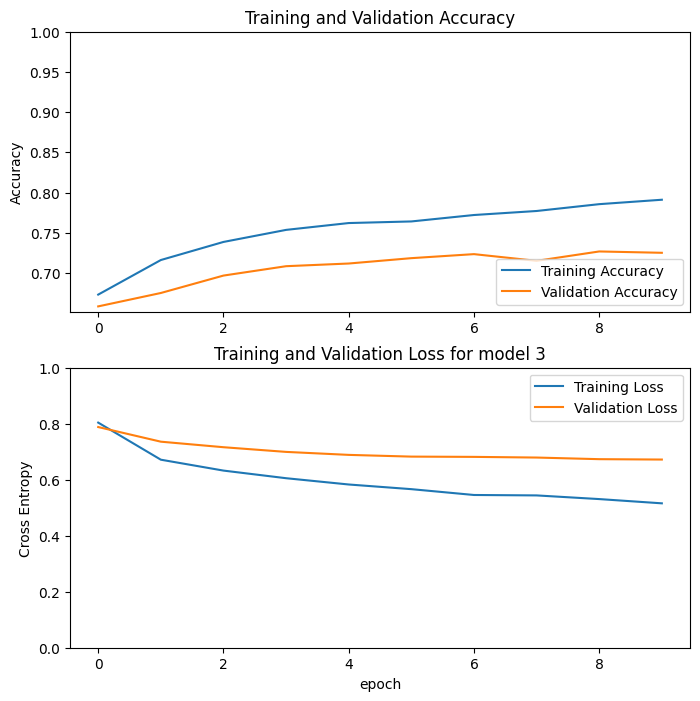

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

matplotlib.pyplot.figure(figsize=(8, 8))
matplotlib.pyplot.subplot(2, 1, 1)
matplotlib.pyplot.plot(acc, label='Training Accuracy')
matplotlib.pyplot.plot(val_acc, label='Validation Accuracy')
matplotlib.pyplot.legend(loc='lower right')
matplotlib.pyplot.ylabel('Accuracy')
matplotlib.pyplot.ylim([min(matplotlib.pyplot.ylim()),1])
matplotlib.pyplot.title('Training and Validation Accuracy')

matplotlib.pyplot.subplot(2, 1, 2)
matplotlib.pyplot.plot(loss, label='Training Loss')
matplotlib.pyplot.plot(val_loss, label='Validation Loss')
matplotlib.pyplot.legend(loc='upper right')
matplotlib.pyplot.ylabel('Cross Entropy')
matplotlib.pyplot.ylim([0,1.0])
matplotlib.pyplot.title('Training and Validation Loss for model 3')
matplotlib.pyplot.xlabel('epoch')
matplotlib.pyplot.show()

In [18]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 4611      
                                                                 
Total params: 10,788,146
Trainable params: 4,611
Non-trainable params: 10,783,535
___________________________________________